In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA

df = pd.read_csv('../data/training_1.csv')
df2 = pd.read_csv('../data/training_2.csv')
df.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,06/01/14 03,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,06/01/14 04,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


In [4]:
# F: Flow data (Liters/second)
# L: Water level (meter)
# P: Pressure (meter?)
# S: switch (binary control signal)

print("\n".join(list(df)))

DATETIME
L_T1
L_T2
L_T3
L_T4
L_T5
L_T6
L_T7
F_PU1
S_PU1
F_PU2
S_PU2
F_PU3
S_PU3
F_PU4
S_PU4
F_PU5
S_PU5
F_PU6
S_PU6
F_PU7
S_PU7
F_PU8
S_PU8
F_PU9
S_PU9
F_PU10
S_PU10
F_PU11
S_PU11
F_V2
S_V2
P_J280
P_J269
P_J300
P_J256
P_J289
P_J415
P_J302
P_J306
P_J307
P_J317
P_J14
P_J422
ATT_FLAG


<IPython.core.display.Javascript object>


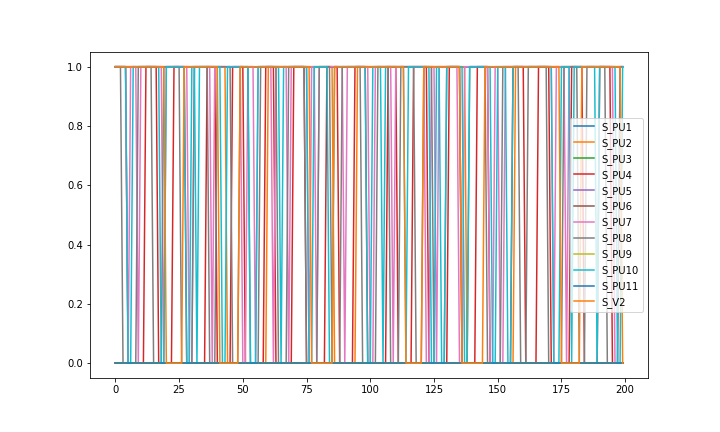

In [130]:
%matplotlib notebook

switches = [x for x in list(df) if x[0] == 'S']

for switch in switches:
    plt.plot(df[switch][:200], label=switch)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


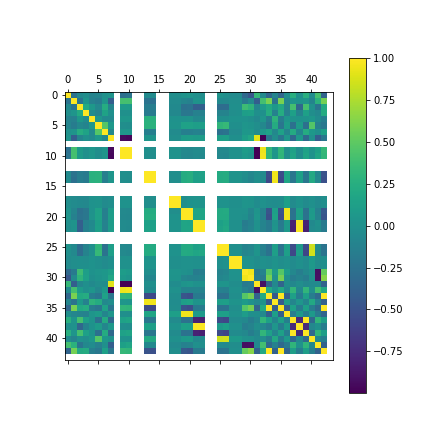

In [72]:
%matplotlib notebook
plt.matshow(df.corr())
plt.colorbar()
plt.show()

           L_T1   L_T2   L_T3   L_T4   L_T5   L_T6   L_T7  F_PU1  S_PU1  \
L_T1       True  False  False  False  False  False  False  False  False   
L_T2      False   True  False  False  False  False  False  False  False   
L_T3      False  False   True  False  False  False  False  False  False   
L_T4      False  False  False   True  False  False  False  False  False   
L_T5      False  False  False  False   True  False  False  False  False   
L_T6      False  False  False  False  False   True  False  False  False   
L_T7      False  False  False  False  False  False   True  False  False   
F_PU1     False  False  False  False  False  False  False   True  False   
S_PU1     False  False  False  False  False  False  False  False  False   
F_PU2     False  False  False  False  False  False  False  False  False   
S_PU2     False  False  False  False  False  False  False  False  False   
F_PU3     False  False  False  False  False  False  False  False  False   
S_PU3     False  False  F

<IPython.core.display.Javascript object>


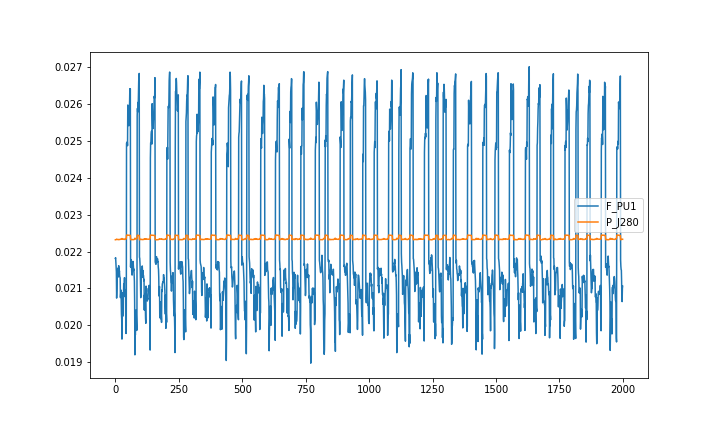

In [109]:
%matplotlib notebook
import sklearn
from sklearn.preprocessing import normalize

corrmat_names = list(df.corr())
sig1 = 7
sig2 = 31

plt.plot(normalize(df[corrmat_names[sig1]][:2000].values.reshape(1, -1)).reshape(-1, 1), label=corrmat_names[sig1])
plt.plot(normalize(df[corrmat_names[sig2]][:2000].values.reshape(1, -1)).reshape(-1, 1), label=corrmat_names[sig2])
plt.legend()
plt.show()

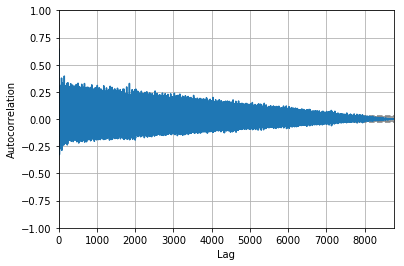

In [150]:
%matplotlib inline
from pandas.plotting import autocorrelation_plot

signal = 'P_J302'

autocorrelation_plot(df[signal])
plt.show()

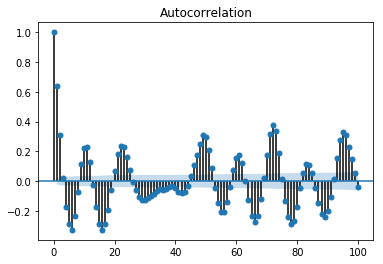

In [152]:
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df[signal], lags=100)
plt.show()

In [154]:
from statsmodels.tsa.ar_model import AR

# train autoregression
model = AR(df[signal])
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)

Lag: 37


In [190]:
from sklearn.metrics import mean_squared_error

model = ARMA(df['F_PU2'], order=(2,4))
model_fit = model.fit()

# print(list(df2))
s = int(len(df['F_PU2'])/10)
e = len(df['F_PU2'])-1
print(mean_squared_error(df['F_PU2'][s-1:e], model_fit.predict(start=s, end=e)))

s = len(df['F_PU2'])
e = len(df['F_PU2']) + len(df2[' F_PU2']) - 1
print(mean_squared_error(df2[' F_PU2'], model_fit.predict(start=s, end=e)))

47.49370154918981
1770.1040059473482
